In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange,tqdm
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time

In [4]:
ROOT='.data'
train_data=datasets.MNIST(root=ROOT,train=True,download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.79MB/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [6]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [7]:
print(f'calculated mean: {mean}')
print(f'calculated std: {std}')

calculated mean: 0.13066047430038452
calculated std: 0.30810779333114624


**Data Augmention**

In [11]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [12]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [13]:
len(train_data)

60000

In [14]:
len(test_data)

10000

**Function to see our images**

In [15]:
def plot_images(images):
  n_images=len(images)
  rows=int(np.sqrt(n_images))
  cols=int(np.sqrt(n_images))
  fig=plt.figure()
  for i in range(rows * cols):
    ax=fig.add_subplot(rows,cols,i+1)
    ax.imshow(images[i].view(28,28).cpu().numpy(),cmap='bone')
    ax.axis('off')

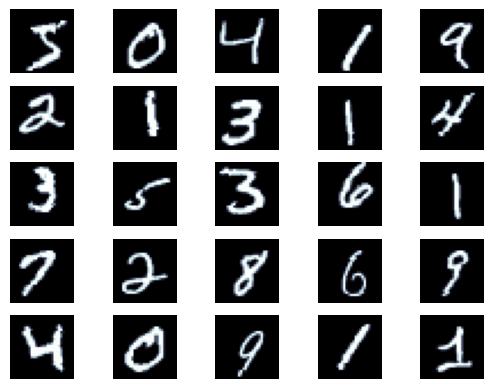

In [16]:
N_IMAGES=25
images=[image for image,label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

**Validation data**

In [20]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [21]:
n_train_examples

54000

In [22]:
n_valid_examples

6000

In [23]:
train_data,valid_data=data.random_split(train_data,[n_train_examples,n_valid_examples])

In [24]:
len(train_data)

54000

In [25]:
len(valid_data)

6000

In [26]:
len(test_data)

10000

**images from validation data**

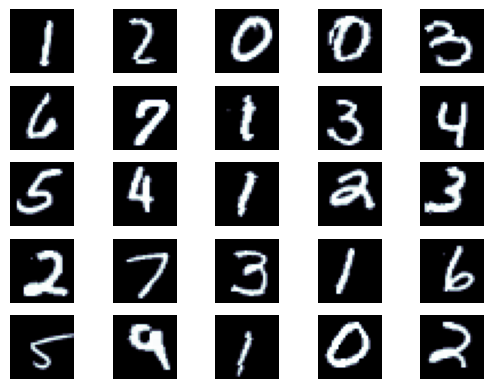

In [27]:
N_IMAGES=25
images=[ image for image,label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

We can now simply replace the validation set's transform by overwriting it with our test transforms from above.

As the validation set is a **Subset** of the training set, if we change the transforms of one, then by default Torchvision will change the transforms of the other. To stop this from happening, we make a **deepcopy** of the validation data.

In [28]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

**after test_tranforms, valid data images**

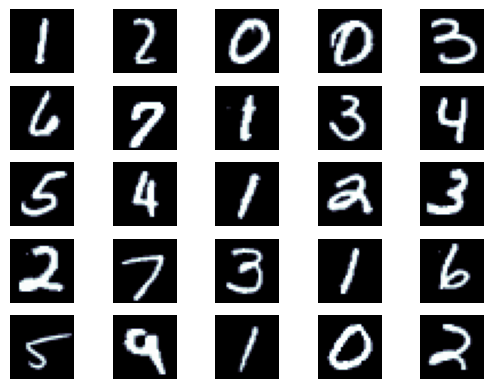

In [29]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [30]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

**Model**

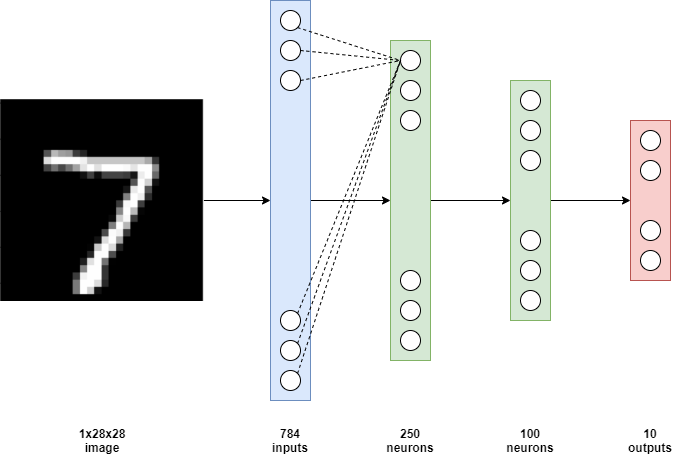

In [31]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2


**Define our model**

In [32]:
INPUT_DIM=28 * 28
OUTPUT_DIM=10
model=MLP(INPUT_DIM,OUTPUT_DIM)

**function to calculate the number of trainable parameters (weights and biases) in our model**

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


**Model Training**

In [35]:
optimizer=optim.Adam(model.parameters())

In [37]:
criterion=nn.CrossEntropyLoss()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
model = model.to(device)
criterion = criterion.to(device)

**function to calculate the accuracy of our model**

In [40]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [42]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [43]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**function to tell us how long an epoch took.**

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [45]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.400 | Train Acc: 87.30%
	 Val. Loss: 0.148 |  Val. Acc: 95.39%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.173 | Train Acc: 94.68%
	 Val. Loss: 0.102 |  Val. Acc: 96.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.138 | Train Acc: 95.77%
	 Val. Loss: 0.082 |  Val. Acc: 97.38%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.119 | Train Acc: 96.19%
	 Val. Loss: 0.081 |  Val. Acc: 97.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.107 | Train Acc: 96.72%
	 Val. Loss: 0.082 |  Val. Acc: 97.17%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.098 | Train Acc: 96.94%
	 Val. Loss: 0.071 |  Val. Acc: 97.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 34s
	Train Loss: 0.094 | Train Acc: 97.17%
	 Val. Loss: 0.063 |  Val. Acc: 98.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 35s
	Train Loss: 0.086 | Train Acc: 97.31%
	 Val. Loss: 0.070 |  Val. Acc: 97.74%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 33s
	Train Loss: 0.084 | Train Acc: 97.41%
	 Val. Loss: 0.065 |  Val. Acc: 97.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 35s
	Train Loss: 0.080 | Train Acc: 97.45%
	 Val. Loss: 0.059 |  Val. Acc: 98.15%


In [46]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

<ipython-input-46-5d8329f6a89e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tut1-model.pt'))


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [47]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.058 | Test Acc: 98.09%


**Examing the model**

In [48]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [49]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

**confusion matrix**

In [50]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

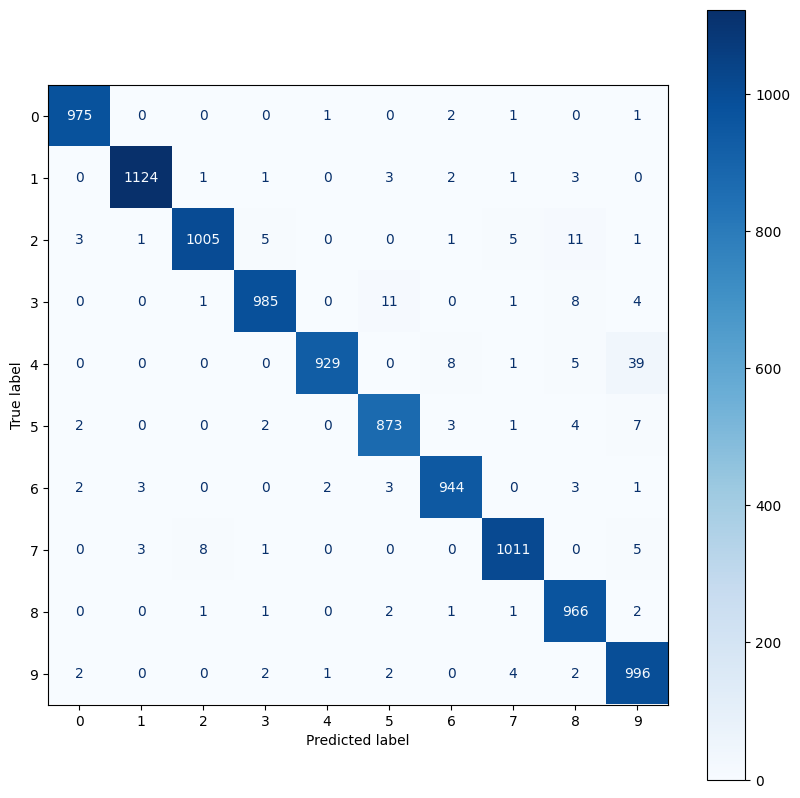

In [51]:
plot_confusion_matrix(labels,pred_labels)

In [52]:
corrects = torch.eq(labels, pred_labels)

We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [53]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [54]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

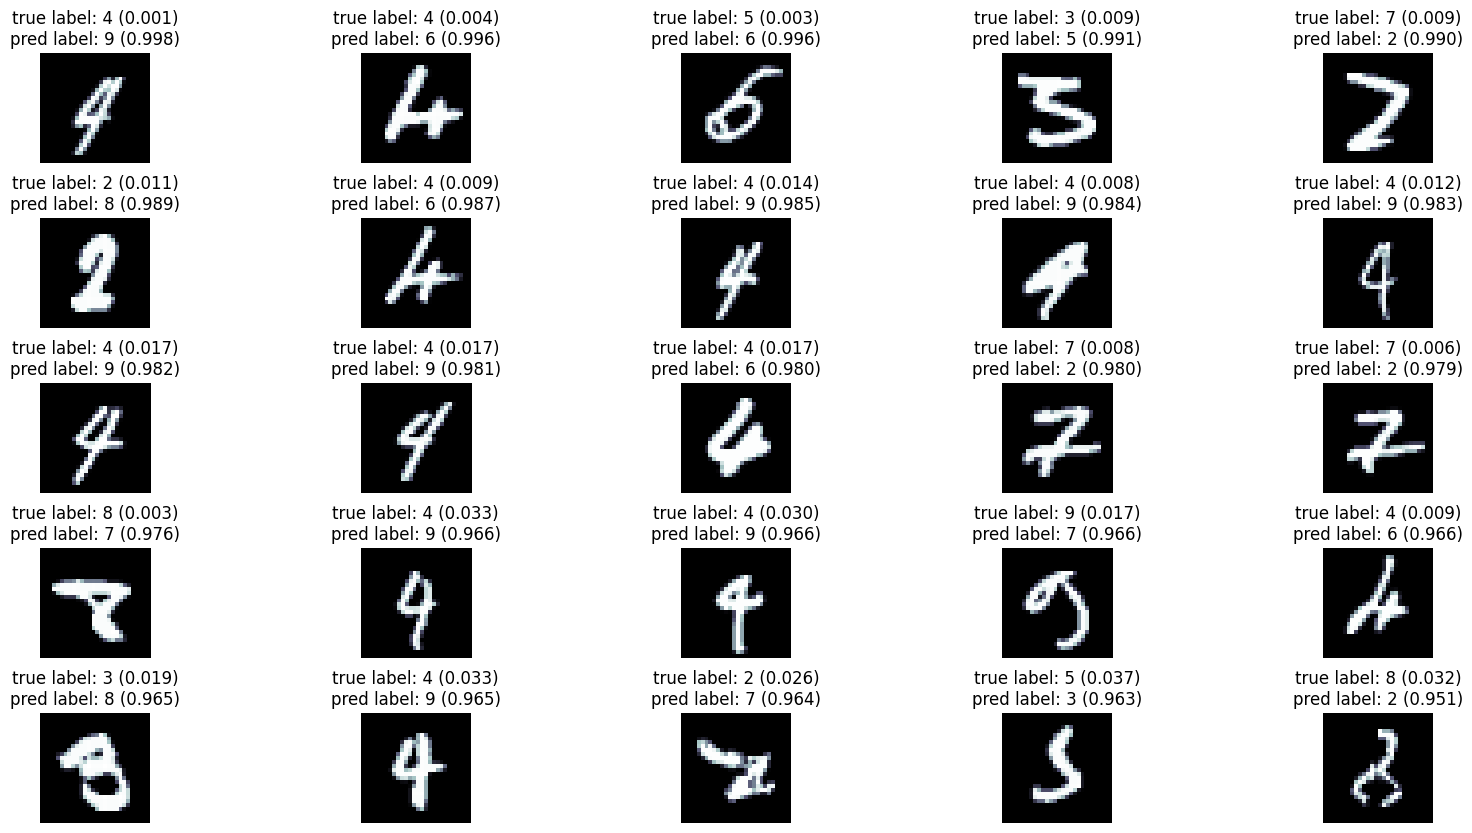

In [55]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Another thing we can do is get the output and intermediate representations from the model and try to visualize them.

The function below loops through the provided dataset and gets the output from the model and the intermediate representation from the layer before that, the second hidden layer.

In [56]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

We run the function to get the representations.

In [57]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

The data we want to visualize is in ten dimensions and 100 dimensions. We want to get this down to two dimensions, so we can actually plot it.

The first technique we'll use is **PCA (principal component analysis)**. First, we'll define a function to calculate the PCA of our data, and then we'll define a function to plot it.

In [58]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [59]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

**First, we plot the representations from the ten dimensional output layer, reduced down to two dimensions.**

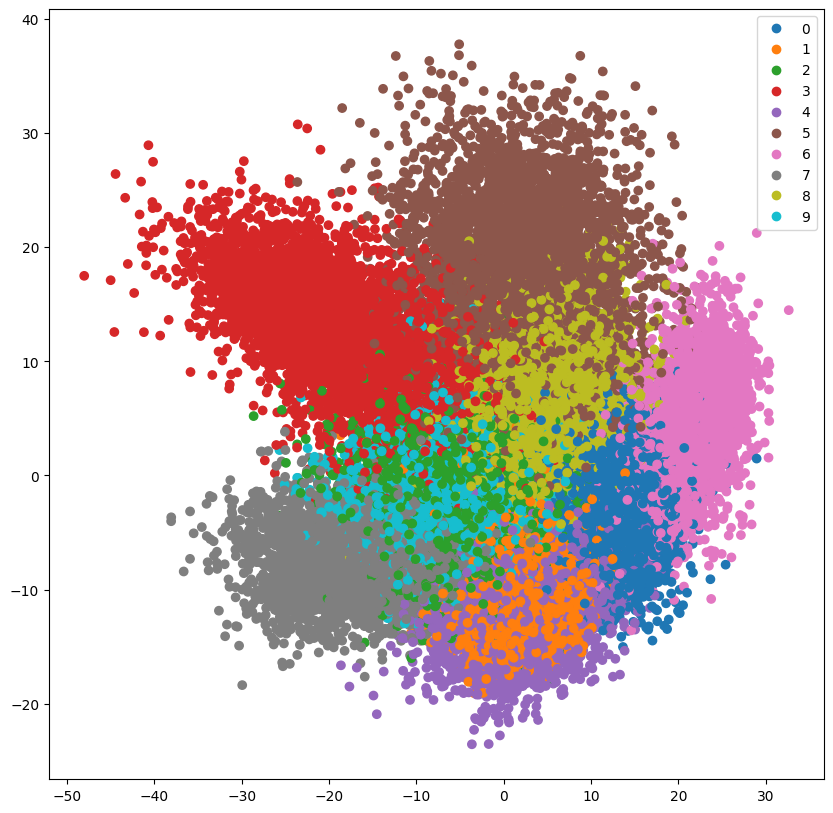

In [60]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

Next, we'll plot the outputs of the second hidden layer.

The clusters seem similar to the one above. In fact if we rotated the below image anti-clockwise it wouldn't be too far off the PCA of the output representations.

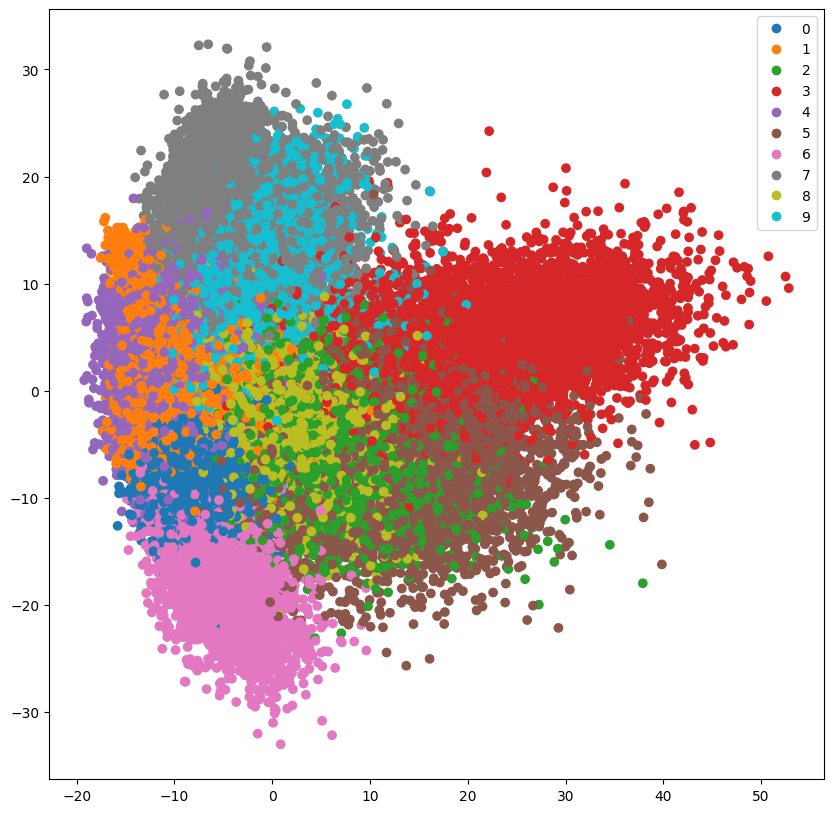

In [61]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

An alternative to PCA is **t-SNE (t-distributed stochastic neighbor embedding)**.

This is commonly thought of as being "better" than PCA, although it can be misinterpreted.

In [62]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

t-SNE is very slow, so we only compute it on a subset of the representations.

The classes look very well separated, and it is possible to use k-NN on this representation to achieve decent accuracy.

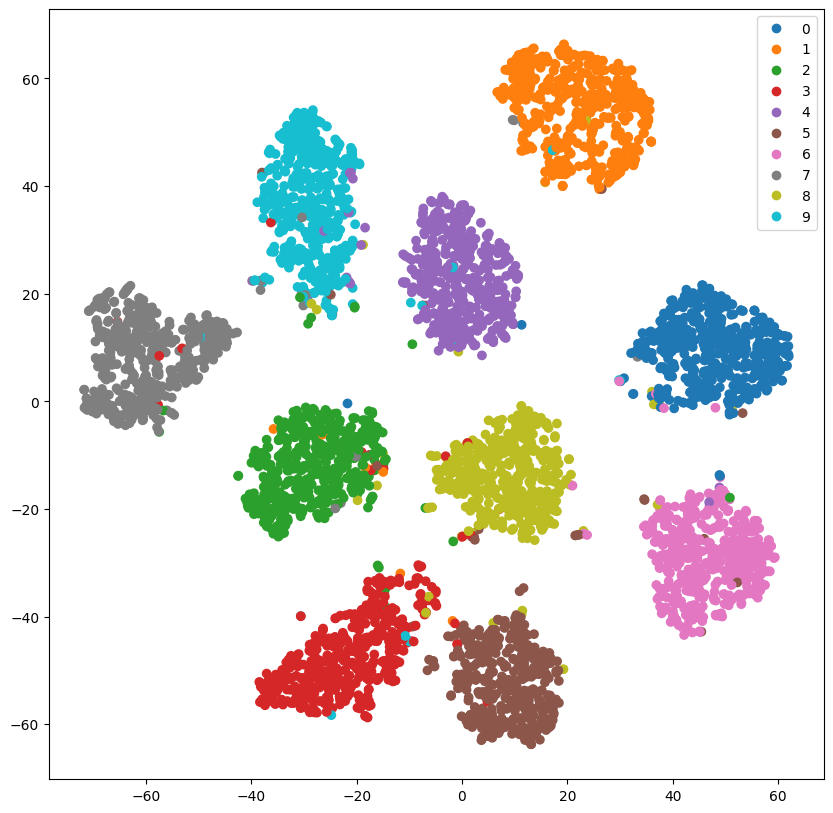

In [63]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

We plot the intermediate representations on the same subset.

Again, the classes look well separated, though less so than the output representations. This is because these representations are intermediate features that the neural network has extracted and will use them in further layers to weigh up the evidence of what digit is in the image. Hence, in theory, the classes should become more separated the closer we are to the output layer, which is exactly what we see here.

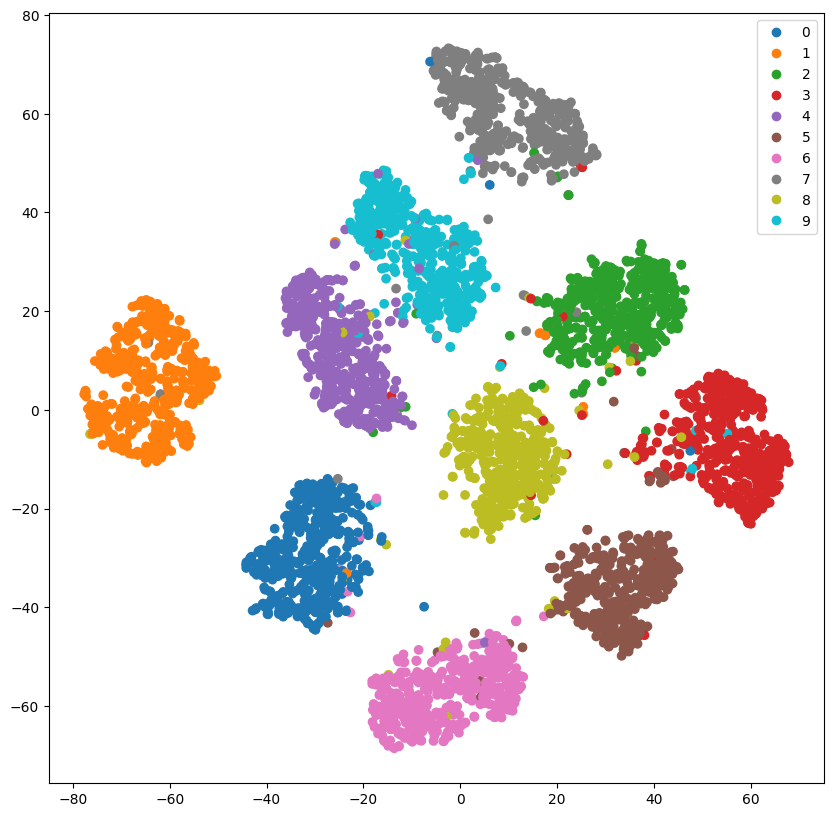

In [64]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

Another experiment we can do is try and generate fake digits.

The function below will repeatedly generate random noise and feed it through the model and find the most confidently generated digit for the desired class.

In [65]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

Let's try and generate a perfect three.



In [66]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

Looking at the best probability achieved, we have a digit that the model is 100% confident is a three.

In [67]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


Unfortunately, the imagined perfect three just looks like random noise.

As mentioned before, the model has only been trained to be incredibly confident with its predictions, so when faced with random noise will try and classify it as something.

It is also possible that the model is overfitting on the training set - that there is a common pattern in handwritten threes within the training set, but it's not the pattern we want our model to learn.

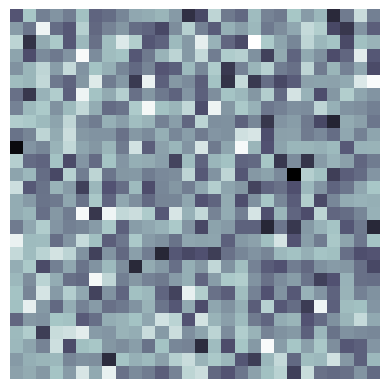

In [68]:
plt.imshow(best_image.cpu().numpy(), cmap='bone')
plt.axis('off');

Finally, we can plot the weights in the first layer of our model.

The hope is that there's maybe one neuron in this first layer that's learned to look for certain patterns in the input and thus has high weight values indicating this pattern. If we then plot these weights, we should see these patterns.

In [69]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Looking at these weights we see a few of them look like random noise but some of them do have weird patterns within them. These patterns show "ghostly" image looking shapes, but are clearly not images.

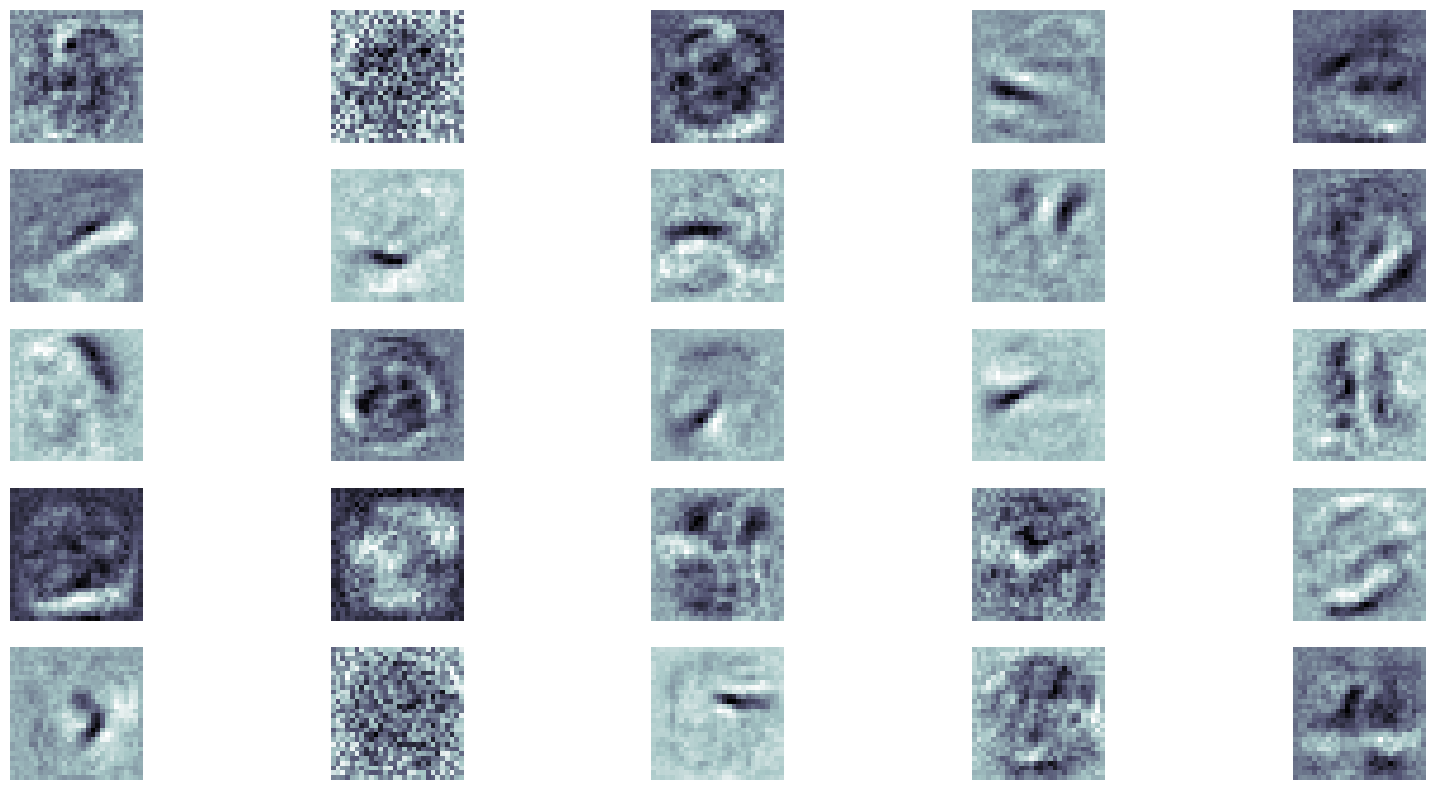

In [70]:
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)